### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [141]:
max_val = []
min_val = []
tmp = np.array(14)
for i in range(len(x[0])):
    for j in range(len(x)):
        tmp = np.append(tmp, x[j][i])
    min_val.append(tmp.min())
    max_val.append(tmp.max())
    tmp = []

NameError: name 'x' is not defined

In [142]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feat_imp = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __gini(self, y):
        print(np.bincount(y), ' !!! ', y.size, ' !!! ', np.bincount(y) / y.size)
        y = np.bincount(y) / y.size
        return 1 - np.sum(np.power(y, 2))

    
    def __entropy(self, y):
        y = np.bincount(y) / y.size
        return -np.dot(y, np.log2(np.where(y==0, 1, y)))
    
    def __error(self, y):
        if y.size == 0:
            return 1
        y = np.bincount(y) / y.size
        return 1 - np.max(y)

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        left = list()
        right = list()
        control = 1
        info = [0,1]
        if self.criterion == 'gini':
            score_func = self.__gini
        elif self.criterion == 'entropy':
            score_func = self.__entropy
        elif self.criterion == 'error':
            score_func = self.__error
        for numb in range(len(x[0])):
            for thresh in np.linspace(min_val[numb],max_val[numb],100):
                for h in range(len(x)):
                    if x[h][numb] > thresh:
                        left.append(y[h])
                    else:
                        right.append(y[h])
                prob_left = {}
                prob_right = {}
                score = (len(right) / (len(left) + len(right)))*score_func(np.array(right)) + (len(left) / (len(left) + len(right)))*score_func(np.array(left))
                if score < control:
                    control = score 
                    info[0] = numb
                    info[1] = thresh
        self.feat_imp[info[0]] += control
        return info[0], info[1] #у нас info[0]-это айди фичи, по которой разбиваем, info[1] - порог

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if len(set(y)) == 1 or depth == self.max_depth or y.size < self.min_samples_split:
            counts = np.bincount(y)
            max_class = np.argmax(counts)
            max_freq = np.max(counts)
            self.tree[node_id] = [1, max_class, max_freq / y.size]
        else:
            feat_id, th = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feat_id, th)
            if y_left.size == 0 or y_right.size == 0:
                self.__make_leaf(node_id, y)
            else:
                self.tree[node_id] = [0, feat_id, th]
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        for feat_num in range(x.shape[1]):
            self.feat_imp[feat_num] = 0
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 
        

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feat_imp

In [255]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feat_imp = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
       
    def __gini(self, y):
        y = np.bincount(y) / y.size
        return 1 - np.sum(np.power(y, 2))
    
    def __entropy(self, y):
        y = np.bincount(y) / y.size
        return -np.dot(y, np.log2(np.where(y==0, 1, y)))
    
    def __error(self, y):
        if y.size == 0:
            return 1
        y = np.bincount(y) / y.size
        return 1 - np.max(y)

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        feat_id, th, score = 0, 0, 0
        feature_num = x.shape[1]
        ex_num = x.shape[0]
        res_x_left, res_x_right, res_y_left, res_y_right = None, None, None, None
        
        if self.criterion == 'gini':
            score_func = self.__gini
        elif self.criterion == 'entropy':
            score_func = self.__entropy
        elif self.criterion == 'error':
            score_func = self.__error
        
        y_score = score_func(y)
        for feature in range(feature_num):
            col = x[:, feature]
            values = np.unique(col)
            for cur_th in values:
                left_mask = col > cur_th
                y_left = y[left_mask]
                y_right = y[~left_mask]
                q = y_score - y_left.size / ex_num * score_func(y_left) \
                        - y_right.size / ex_num * score_func(y_right)
                if q > score:
                    score = q
                    feat_id, th = feature, cur_th
        
        self.feat_imp[feat_id] += score
        return feat_id, th
    
    def __make_leaf(self, node_id, y):
        counts = np.bincount(y)
        max_class = np.argmax(counts)
        max_freq = np.max(counts)
        self.tree[node_id] = [1, max_class, max_freq / y.size]

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth == self.max_depth or y.size < self.min_samples_split or np.unique(y).size == 1:
            self.__make_leaf(node_id, y)
            
        else:
            feat_id, th = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feat_id, th)
            if y_left.size == 0 or y_right.size == 0:
                self.__make_leaf(node_id, y)
            else:
                self.tree[node_id] = [0, feat_id, th]
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
        
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        for feat_num in range(x.shape[1]):
            self.feat_imp[feat_num] = 0
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feat_imp

In [144]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [145]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [267]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [268]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [271]:
%time clf.fit(X_train, y_train)

CPU times: user 1.68 ms, sys: 526 µs, total: 2.2 ms
Wall time: 1.71 ms


DecisionTreeClassifier()

In [272]:
%time my_clf.fit(X_train, y_train)

CPU times: user 160 ms, sys: 2.9 ms, total: 163 ms
Wall time: 165 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [217]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]

In [218]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

In [219]:
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)

In [220]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

In [221]:
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)
df = pd.concat([df.drop(['field_cd'], axis=1), pd.get_dummies(df['field_cd'], prefix='field_cd')], axis=1)

In [222]:
df = df.drop(['undergra'], axis=1)
df = df.drop(['mn_sat'], axis=1)
df = df.drop(['tuition'], axis=1)
df = df.drop(['race'], axis=1)
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df = df.drop(['income'], axis=1)
df = df.dropna(subset=['date'])
df = df.drop(['go_out'], axis=1)
df = df.dropna(subset=['goal'])

In [223]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)
df = pd.concat([df.drop(['career_c'], axis=1), pd.get_dummies(df['career_c'], prefix='career_c')], axis=1)

In [224]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
df = df.drop(['expnum'], axis=1)

In [225]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [226]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

In [227]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)


In [228]:
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

In [229]:
df = df_male.merge(df_female, how='inner', left_on='pid', right_on='iid_f')

In [230]:
y = df['match'].values

In [231]:
df = df.drop(['match', 'iid', 'pid', 'iid_f', 'pid_f'], axis=1)

In [232]:
X = df.values

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [247]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.758
0.837


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [248]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [250]:
scores = {}
for cr in ['gini', 'entropy', 'error']:
    cur_sc = []
    clf = MyDecisionTreeClassifier(criterion=cr)
    for train, test in KFold(5).split(X_train, y_train):
        clf.fit(X_train[train], y_train[train])
        cur_sc.append(roc_auc_score(clf.predict(X_train[test]), y_train[test]))
    scores[cr] = np.mean(np.array(cur_sc))

print('ROC-AUC score:')
scores

ROC-AUC score:


{'gini': 0.5677400587214386,
 'entropy': 0.5088358499003098,
 'error': 0.652331331204136}

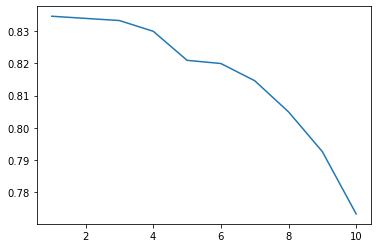

In [251]:
scores = []
for depth in range(1, 11):
    cur_sc = []
    for train, test in KFold(5).split(X_train, y_train):
        clf = MyDecisionTreeClassifier(criterion='error', max_depth=depth)
        clf.fit(X_train[train], y_train[train])
        cur_sc.append(accuracy_score(clf.predict(X_train[test]), y_train[test]))
    scores.append(np.mean(np.array(cur_sc)))
plt.plot(range(1, 11), scores)

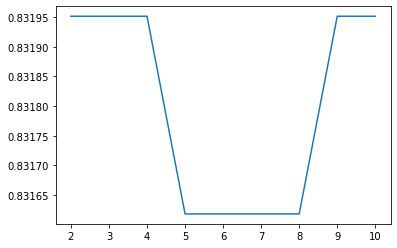

In [252]:
scores = []
for split_size in range(2, 11):
    cur_sc = []
    for train, test in KFold(5).split(X_train, y_train):
        clf = MyDecisionTreeClassifier(criterion='error', min_samples_split=split_size)
        clf.fit(X_train[train], y_train[train])
        cur_sc.append(accuracy_score(clf.predict(X_train[test]), y_train[test]))
    scores.append(np.mean(np.array(cur_sc)))
plt.plot(range(2, 11), scores)

Максимальный accuracy_score составил 0.84

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [256]:
clf = MyDecisionTreeClassifier(min_samples_split=9, max_depth=5, criterion='error')
clf.fit(X, y)

In [258]:
vals = np.array(list(clf.get_feature_importance().values()))
indices = np.argsort(vals)[:-11:-1]
names = df.columns[indices]
vals = vals[indices]
for i in range(10):
    print(names[i], ': ', vals[i])

field_cd_13.0_f :  0.06666666666666668
exphappy :  0.05769230769230772
fun1_1 :  0.03947368421052623
age :  0.037974683544303806
fun1_1_f :  0.027397260273972643
int_corr :  0.0002500625156289548
sinc1_1 :  1.734723475976807e-17
career_c_11.0 :  0.0
career_c_1.0 :  0.0
field_cd_10.0 :  0.0


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

